In [17]:
!pip install shap

     |████████████████████████████████| 326 kB 10.8 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=447242 sha256=8e3e43d34fe2417f865423ff46d3076d3caa9b69eb60533e50df8d4a5149fb61
  Stored in directory: /home/ec2-user/.cache/pip/wheels/9f/f0/81/55d1fce3ccceacb520abc45e88f3d2de2959cd079f712b5f85
Successfully built shap
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [29]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import math

from utilities.data import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

loader = DataLoader(use_data_pt2=True)
#grenade_df = loader.load_grenade_df(nrows=20000)
#print(grenade_df.info())
#print(grenade_df.isnull().sum())
#kill_df = loader.load_kill_df()
#print(kills_df.info())
#dmg_df = loader.load_dmg_df(nrows=20000)
#dmg_df = dmg_df[(~dmg_df['seconds'].isna())]
#print(dmg_df.info())
#print(dmg_df.isnull().sum())
cluster_df = loader.load_firefight_df(map_name='de_mirage')
print(cluster_df.info())
cluster_df = cluster_df[cluster_df['att_side'] != 'None']
cluster_df = cluster_df[cluster_df['seconds'] != 'None']
print(cluster_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2271942 entries, 0 to 2271941
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   winner_side  object 
 1   att_side     object 
 2   map          object 
 3   seconds      float64
 4   pos_x        float64
 5   pos_y        float64
 6   hp_dmg       float64
 7   pos_type     object 
 8   index        int64  
 9   file_round   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 173.3+ MB
None
winner_side      0
att_side         0
map              0
seconds        500
pos_x            0
pos_y            0
hp_dmg           0
pos_type         0
index            0
file_round       0
dtype: int64
['CounterTerrorist' 'Terrorist']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2254374 entries, 0 to 2271941
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   winner_side  object 
 1   att_side     object 
 2   map          object 
 3   seconds      float64
 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


winner_side      0
att_side         0
map              0
seconds        500
pos_x            0
pos_y            0
hp_dmg           0
pos_type         0
index            0
file_round       0
dtype: int64


In [35]:
# Cluster spatially
from sklearn.cluster import DBSCAN
min_samples = 80
print(f"min_samples: {min_samples}")
pos_type_eps = {'DMG': DBSCAN(eps=0.003, min_samples=120),
                'Smoke': DBSCAN(eps=0.004, min_samples=min_samples), 
                'Flash': DBSCAN(eps=0.0036, min_samples=100), 
                'HE': DBSCAN(eps=0.004, min_samples=min_samples), 
                'Incendiary': DBSCAN(eps=0.004, min_samples=min_samples), 
                'Molotov': DBSCAN(eps=0.004, min_samples=min_samples)}
cluster_df = cluster_positions(cluster_df, cluster_map=pos_type_eps, verbose=True)
print(cluster_df.isna().sum())

min_samples: 80
CounterTerrorist, Smoke, de_mirage: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17]), array([26955, 73460, 57752, 35158, 14493,  5142,  1628,  4636,  3295,
         294,   188,   591,   995,   310,   545,   111,   196,   227,
          83]))
CounterTerrorist, HE, de_mirage: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25]), array([31800, 93927,  9175, 50228,  1384, 10286,   354,  9140,   592,
        1158,  1776,  3507,   149,  1137,   487,  1292,   217,   127,
         163,   145,   209,   166,    97,   124,    98,    83,    80]))
CounterTerrorist, Incendiary, de_mirage: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]), array([29101, 73653, 18970, 72147, 10917,  7118, 25048,  3018,  8468,
        7510,  1458,  1277,   171,   180,   190,   414,   122,   213,
         205,   153

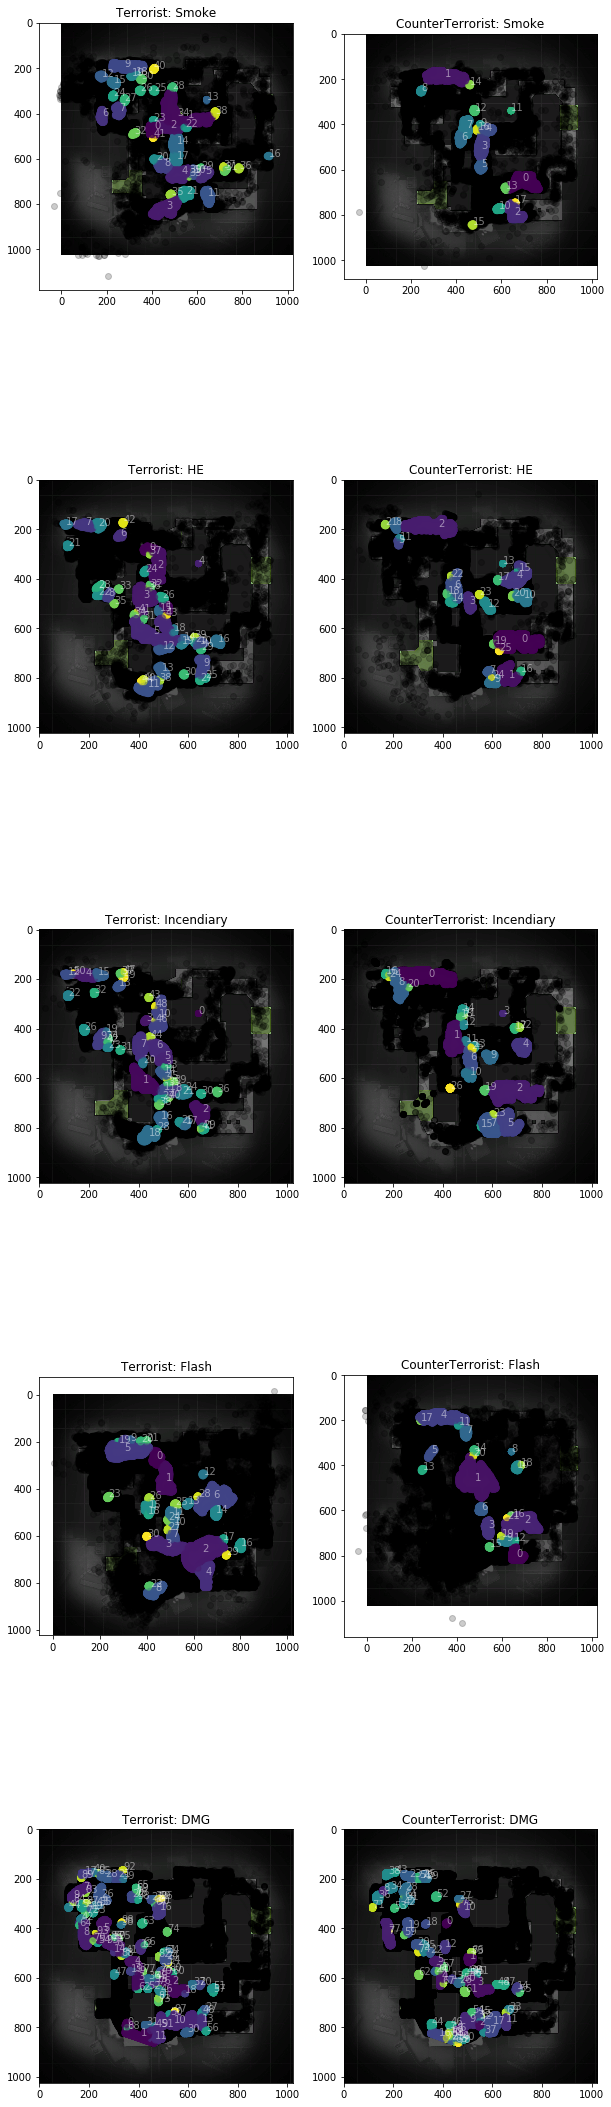

In [34]:
from sklearn.neighbors.nearest_centroid import NearestCentroid

def visualize_pos_clusters(cluster_df, map_name):
    cluster_df = cluster_df[cluster_df['map'] == map_name]
    teams = ['Terrorist', 'CounterTerrorist']
    pos_types = [t for t in cluster_df['pos_type'].unique() if t not in ['DMG_VIC', 'DMG_ATT']]
    map_filenames = {map_name: f'../data/{map_name}.png' for map_name in cluster_df['map'].unique()}
    fig, axes = plt.subplots(len(pos_types)+1, len(teams), figsize=(10,40))

    for i, team in enumerate(teams):
        for j, pos_type in enumerate(pos_types):
            df = cluster_df[(cluster_df['att_side'] == team) & (cluster_df['pos_type'] == pos_type)]            
            axes[j, i].set_title(f'{team}: {pos_type}')
            im = plt.imread(map_filenames[map_name])
            axes[j, i].imshow(im)
            not_clustered = df[df['pos_cluster'] == -1]
            axes[j, i].scatter(not_clustered['pos_x'], not_clustered['pos_y'], c='black', alpha=0.2)
            df = df[df['pos_cluster'] != -1]
            axes[j, i].scatter(df['pos_x'], df['pos_y'], c=df['pos_cluster'], alpha=0.5)
            try:
                centroids = NearestCentroid()
                pts = pd.concat([df['pos_x'], df['pos_y']], axis=1)
                centroids.fit(pts, df['pos_cluster'].astype('int'))    
                nade_clusters = centroids.centroids_
                for k, pos in enumerate(zip(nade_clusters[:, 0], nade_clusters[:, 1])):
                    axes[j, i].annotate(str(k), pos, color='white', fontsize=10, alpha=0.5)
            except:
                pass
        df = cluster_df[(cluster_df['att_side'] == team) & ((cluster_df['pos_type'] == 'DMG_ATT') | (cluster_df['pos_type'] == 'DMG_VIC'))]            
        axes[len(pos_types), i].set_title(f'{team}: DMG')
        im = plt.imread(map_filenames[map_name])
        axes[len(pos_types), i].imshow(im)
        not_clustered = df[df['pos_cluster'] == -1]
        axes[len(pos_types), i].scatter(not_clustered['pos_x'], not_clustered['pos_y'], c='black', alpha=0.2)
        df = df[df['pos_cluster'] != -1]
        axes[len(pos_types), i].scatter(df['pos_x'], df['pos_y'], c=df['pos_cluster'], alpha=0.5)
        try:
            centroids = NearestCentroid()
            pts = pd.concat([df['pos_x'], df['pos_y']], axis=1)
            centroids.fit(pts, df['pos_cluster'].astype('int'))    
            nade_clusters = centroids.centroids_
            for k, pos in enumerate(zip(nade_clusters[:, 0], nade_clusters[:, 1])):
                axes[len(pos_types), i].annotate(str(k), pos, color='white', fontsize=10, alpha=0.5)
        except:
            pass
    plt.show()
visualize_pos_clusters(cluster_df, 'de_mirage')

In [ ]:
# Larger eps = bigger clusters
cluster_df = cluster_firefights(cluster_df, eps=0.09, min_samples=6, n_seconds_equiv_to_quarter_map=20, verbose=True)
print(cluster_df.head(5))

POS CLUSTERS: [-1.  0.  1.  2.  3.  7.  9. 26. 94. 95.]
FIREFIGHT CLUSTERS: [-1]
1078    95.0
1079     0.0
1080    -1.0
1081     9.0
1082     2.0
1083     2.0
1084     2.0
1085     3.0
1086    -1.0
1087     2.0
1088     1.0
1089     0.0
1090    94.0
1091    -1.0
1092     7.0
1093    26.0
Name: pos_cluster, dtype: float64


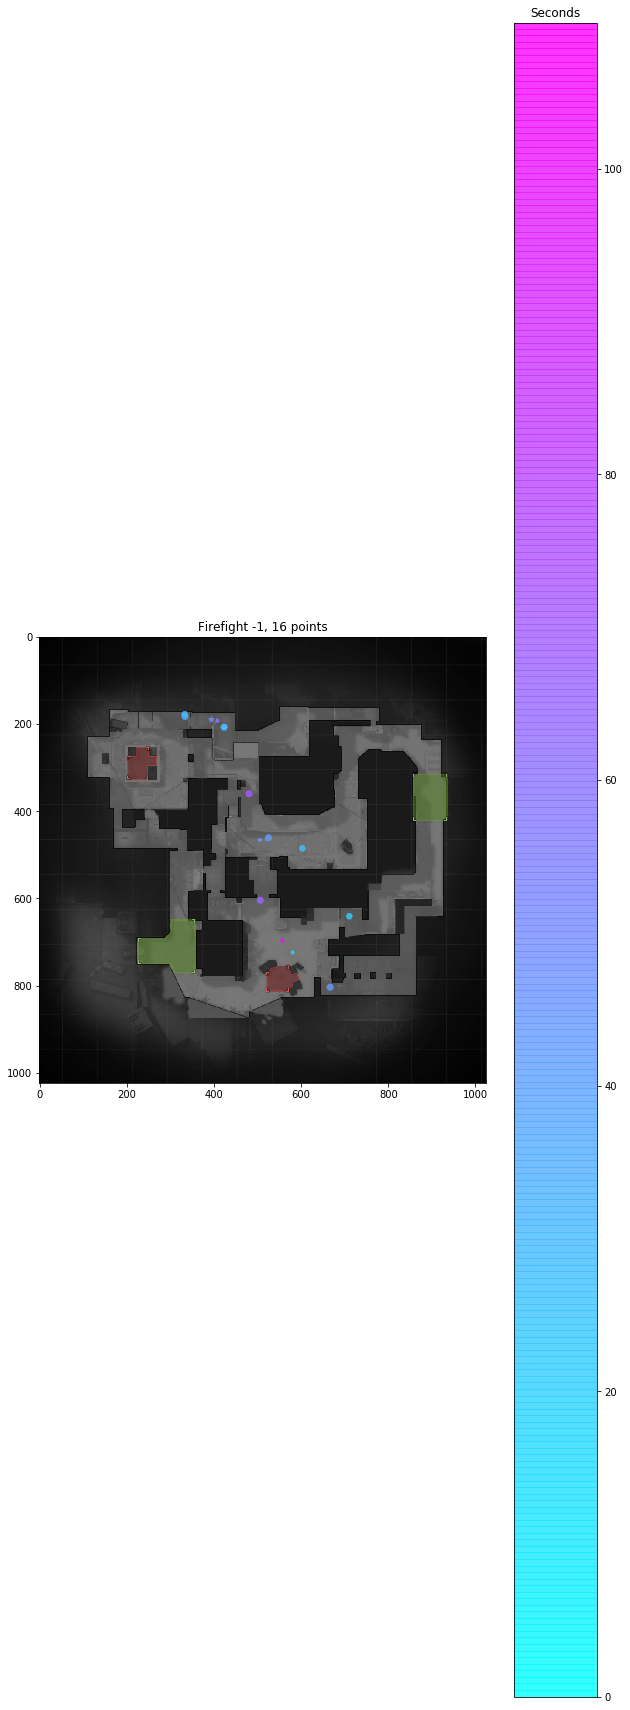

In [28]:
import matplotlib as mpl

map_filenames = {map_name: f'../data/{map_name}.png' for map_name in cluster_df['map'].unique()}
def visualize_ff_clusters(cluster_df, file_round):
    df = cluster_df[cluster_df['file_round'] == file_round]
    print(f"POS CLUSTERS: {np.unique(df['pos_cluster'])}")
    print(f"FIREFIGHT CLUSTERS: {np.unique(df['firefight_cluster'])}")
    print(df['pos_cluster'])
    num_pos_clusters = len(np.unique(df['pos_cluster']))
    num_ff_clusters = len(np.unique(df['firefight_cluster']))
    fig, axes = plt.subplots(num_ff_clusters, figsize=(10,36))
    if len(np.unique(df['firefight_cluster'])) == 1:
          axes = [axes]
    #for i, pos_cluster in enumerate(np.unique(df['pos_cluster'])):
    #    axes[i, 0].set_title(f'Cluster {i}')
    #    pts = df[df['pos_cluster'] == pos_cluster]
    #    map_name = pts.iloc[0]['map']
    #    im = plt.imread(map_filenames[map_name])
    #    axes[i, 0].imshow(im)
    #    axes[i, 0].scatter(pts['pos_x'], pts['pos_y'], c=pts['seconds'])
    norm = mpl.colors.Normalize(vmin=0, vmax=max(df['seconds']))
    cmap = mpl.cm.cool
    for i, firefight_cluster in enumerate(np.unique(df['firefight_cluster'])):
        pts = df[df['firefight_cluster'] == firefight_cluster]
        axes[i].set_title(f'Firefight {firefight_cluster}, {len(pts)} points')
        map_name = pts.iloc[0]['map']
        im = plt.imread(map_filenames[map_name])
        axes[i].imshow(im)
        markers = {'DMG_ATT': '^', 'DMG_VIC': 'X', 'Smoke': 'o', 'HE': 'H', 'Flash': '.', 'Molotov': '*', 'Incendiary': '*', }
        for pt_type, marker in markers.items():
            pts_type = pts[pts['pos_type'] == pt_type]
            sct = axes[i].scatter(pts_type['pos_x'], pts_type['pos_y'], c=pts_type['seconds'], marker=marker, cmap='cool', norm=norm, alpha=0.8)
        cb = plt.colorbar(sct, ax=axes[i])
        cb.ax.set_title('Seconds')
    plt.show()
visualize_ff_clusters(cluster_df, 'esea_match_13779815.dem_3')

POS CLUSTERS: [-1.  0.]
FIREFIGHT CLUSTERS: [-1 0]
84    0.0
85   -1.0
86   -1.0
87   -1.0
88   -1.0
89    0.0
90   -1.0
91    0.0
92   -1.0
93   -1.0
Name: pos_cluster, dtype: float64


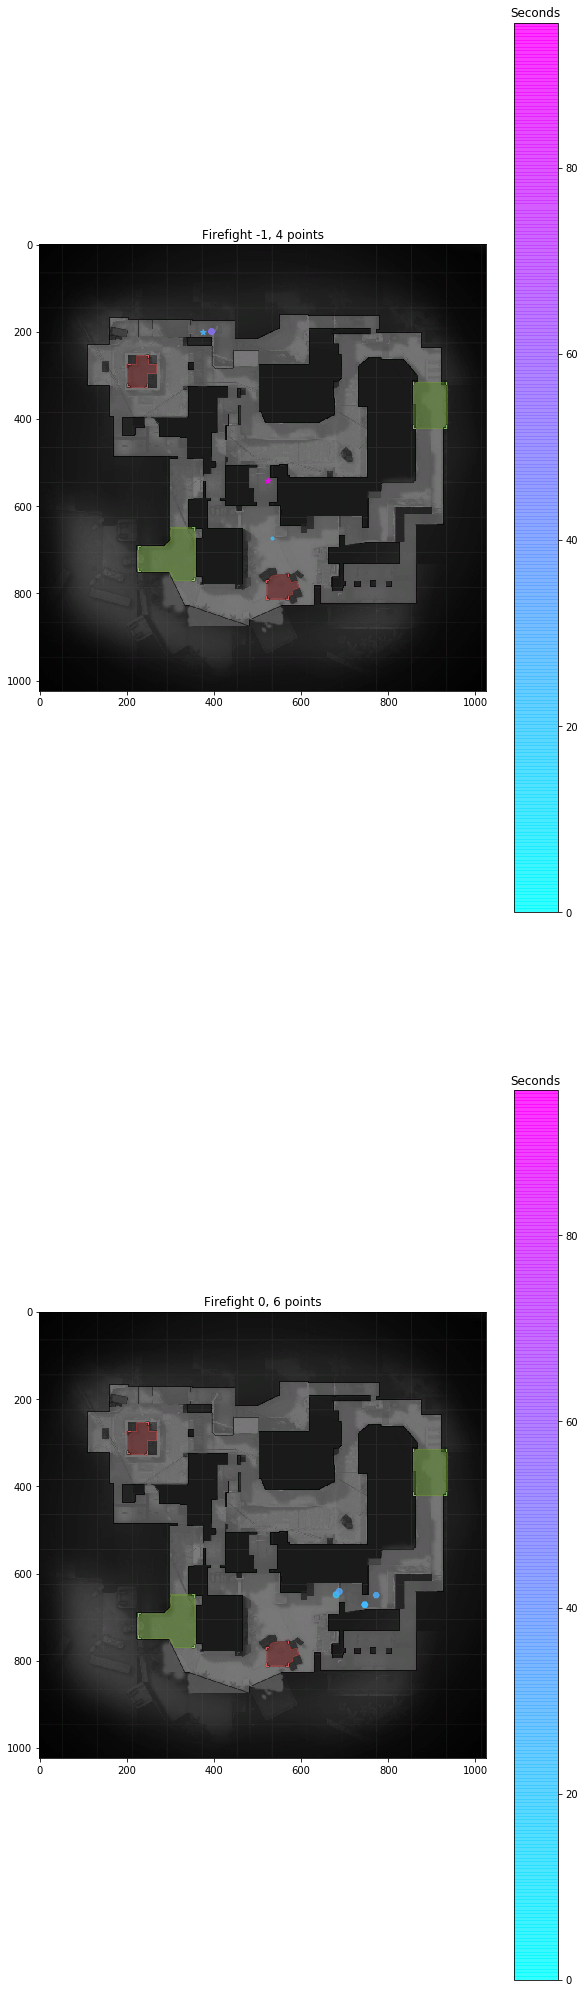

In [23]:
visualize_ff_clusters(cluster_df, 'esea_match_13779770.dem_9')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/home/ec2-use

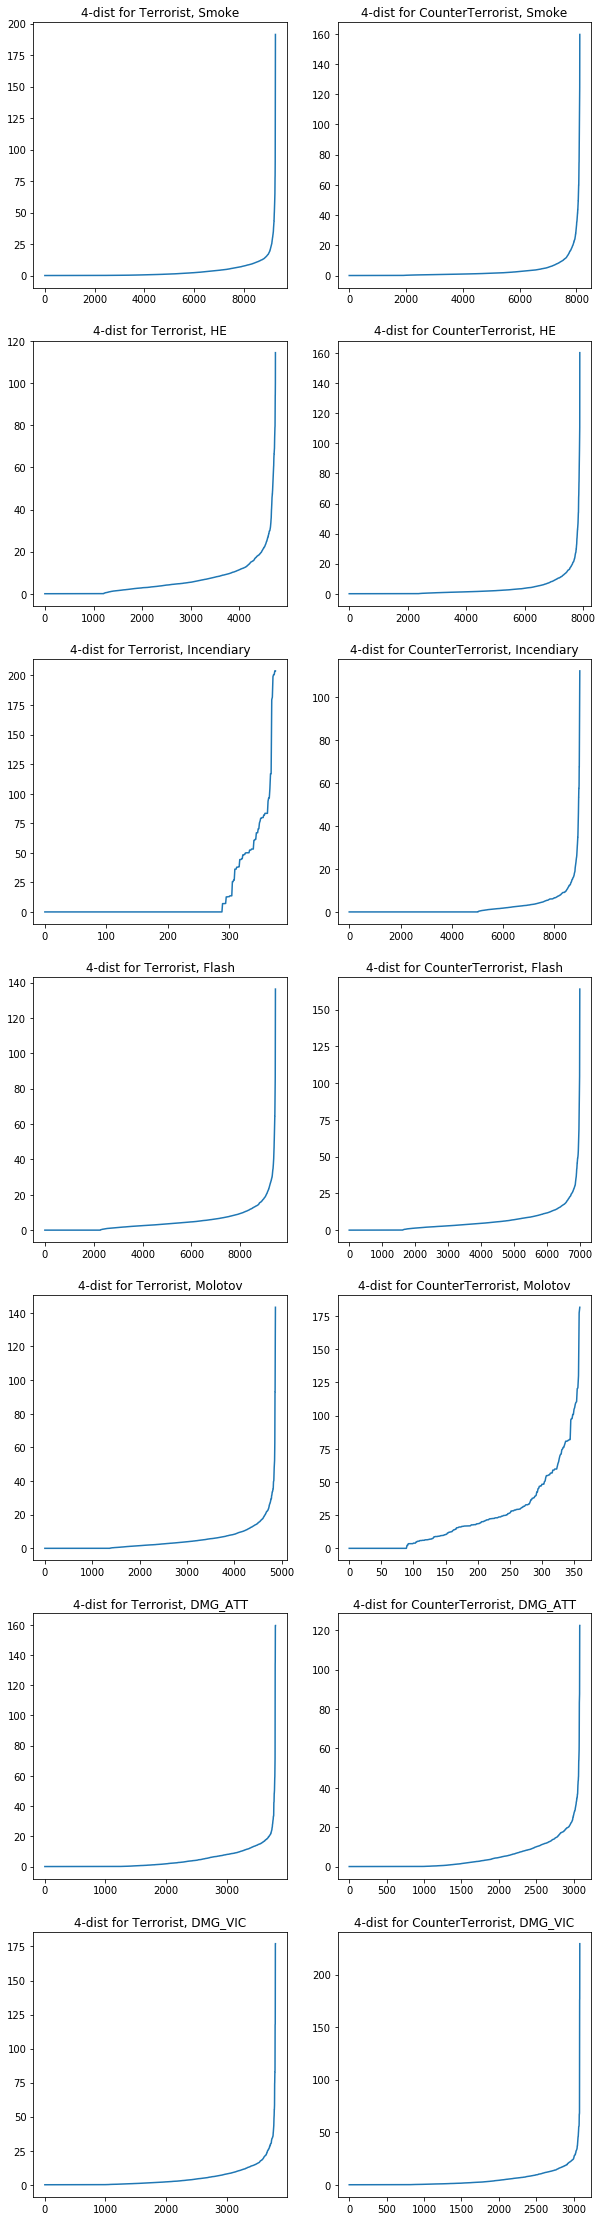

In [20]:
# https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf
def k_distances2(x, k):
    dim0 = x.shape[0]
    dim1 = x.shape[1]
    p=-2*x.dot(x.T)+np.sum(x**2, axis=1).T+ np.repeat(np.sum(x**2, axis=1),dim0,axis=0).reshape(dim0,dim0)
    p = np.sqrt(p)
    p.sort(axis=1)
    p=p[:,:k]
    pm= p.flatten()
    pm= np.sort(pm)
    return p, pm


def visualize_k_distance(cluster_df, map_name):
    cluster_df = cluster_df[cluster_df['map'] == map_name]
    teams = ['Terrorist', 'CounterTerrorist']
    pos_types = cluster_df['pos_type'].unique()
    fig, axes = plt.subplots(len(pos_types), len(teams), figsize=(10,40))

    for i, team in enumerate(teams):
        for j, pos_type in enumerate(pos_types):
            df = cluster_df[(cluster_df['att_side'] == team) & (cluster_df['pos_type'] == pos_type)]
            p, pm = k_distances2(df[['pos_x', 'pos_y']].values, 4)
            axes[j, i].plot(pm)
            axes[j, i].set_title(f'4-dist for {team}, {pos_type}')
            #axes[j, i].ylabel('n');
            #axes[j, i].xlabel('Epsilon distance');
            
    plt.show()
visualize_k_distance(cluster_df, 'de_mirage')

Plotting for eps=0.08 and n_secs=10
Plotting for eps=0.08 and n_secs=20
Plotting for eps=0.08 and n_secs=30
Plotting for eps=0.09 and n_secs=10
Plotting for eps=0.09 and n_secs=20
Plotting for eps=0.09 and n_secs=30
Plotting for eps=0.09999999999999999 and n_secs=10
Plotting for eps=0.09999999999999999 and n_secs=20
Plotting for eps=0.09999999999999999 and n_secs=30
Plotting for eps=0.10999999999999999 and n_secs=10
Plotting for eps=0.10999999999999999 and n_secs=20
Plotting for eps=0.10999999999999999 and n_secs=30
Plotting for eps=0.11999999999999998 and n_secs=10
Plotting for eps=0.11999999999999998 and n_secs=20
Plotting for eps=0.11999999999999998 and n_secs=30


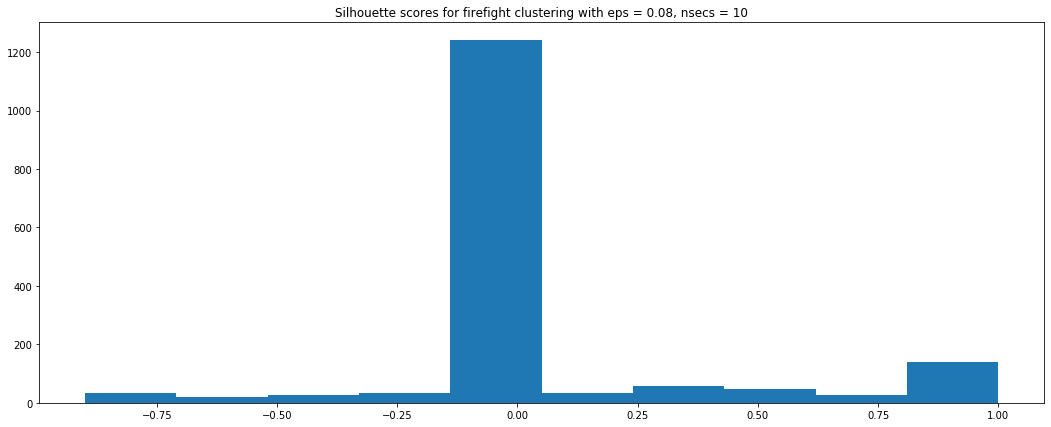

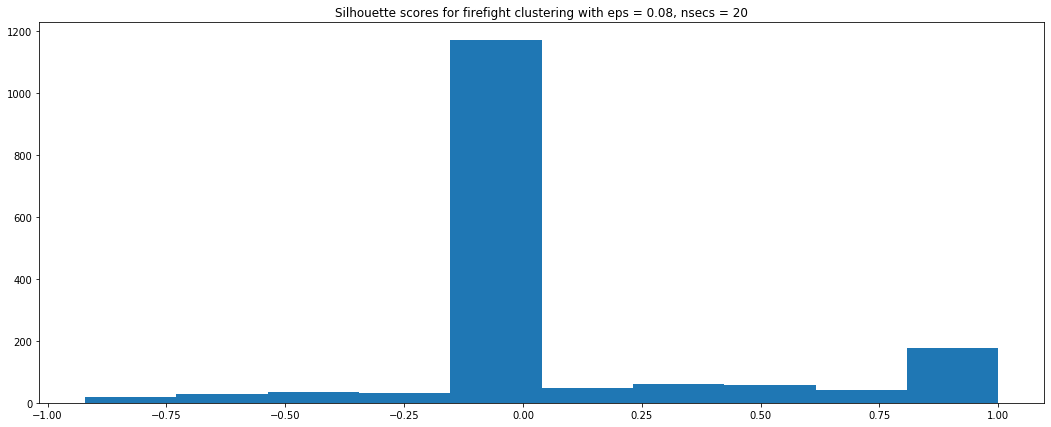

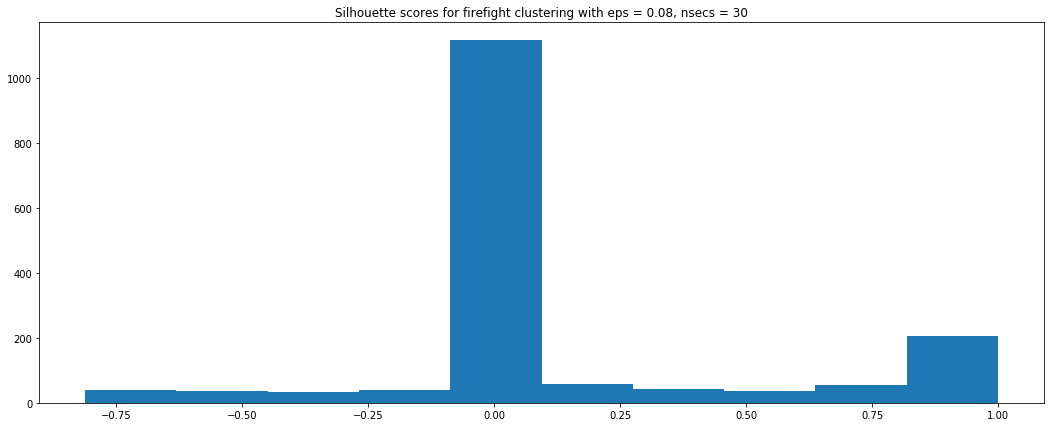

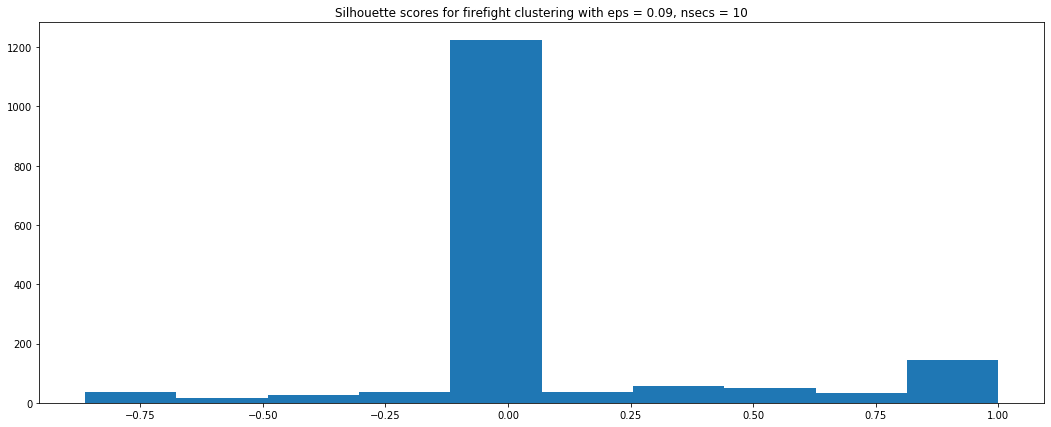

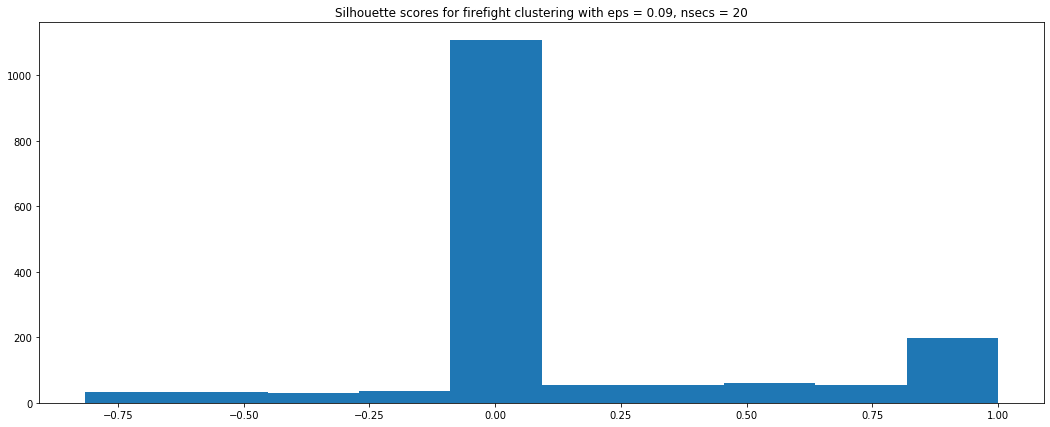

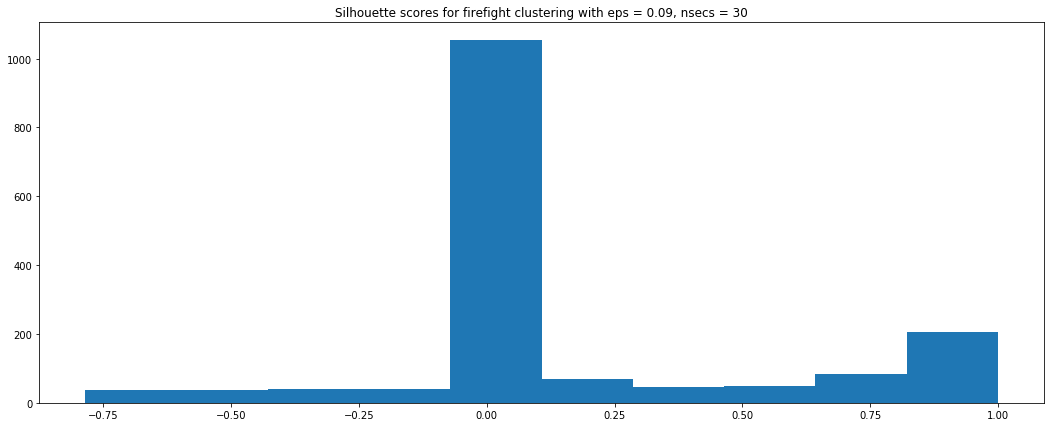

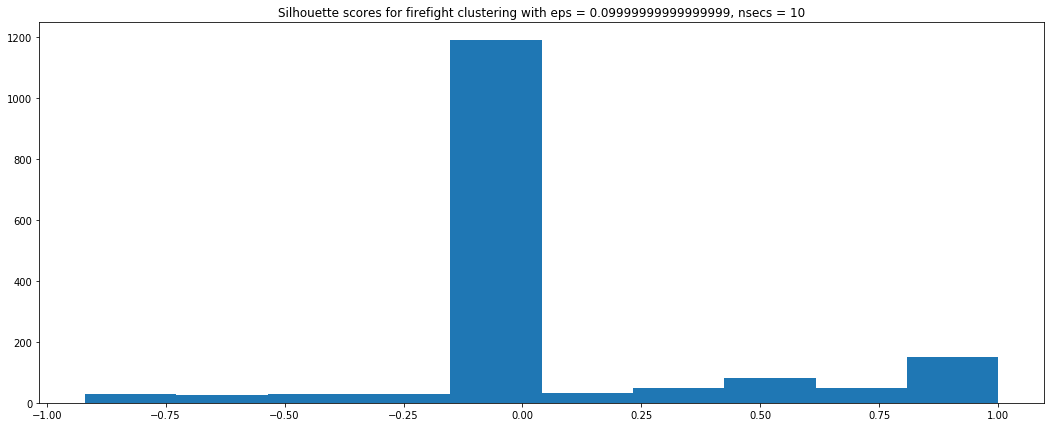

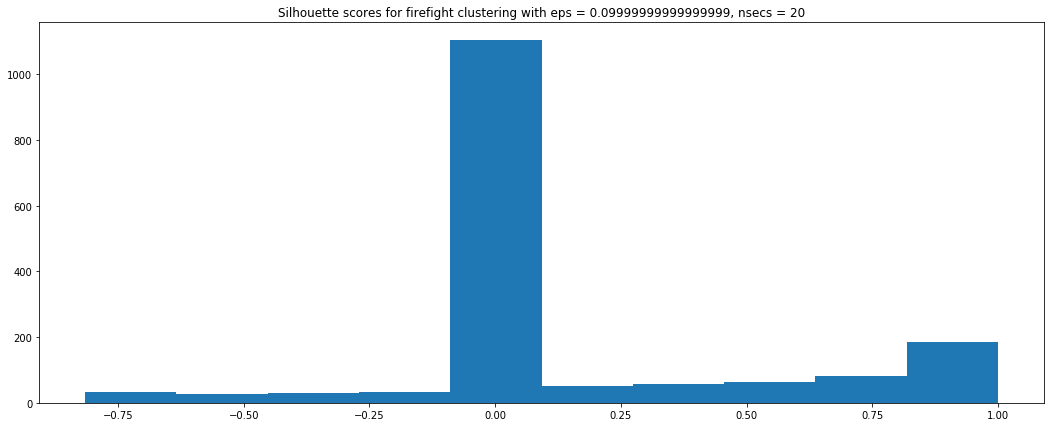

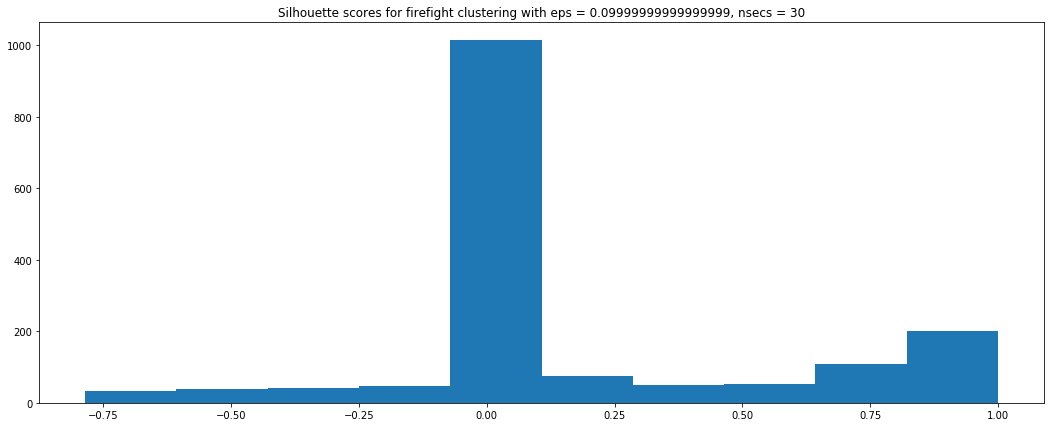

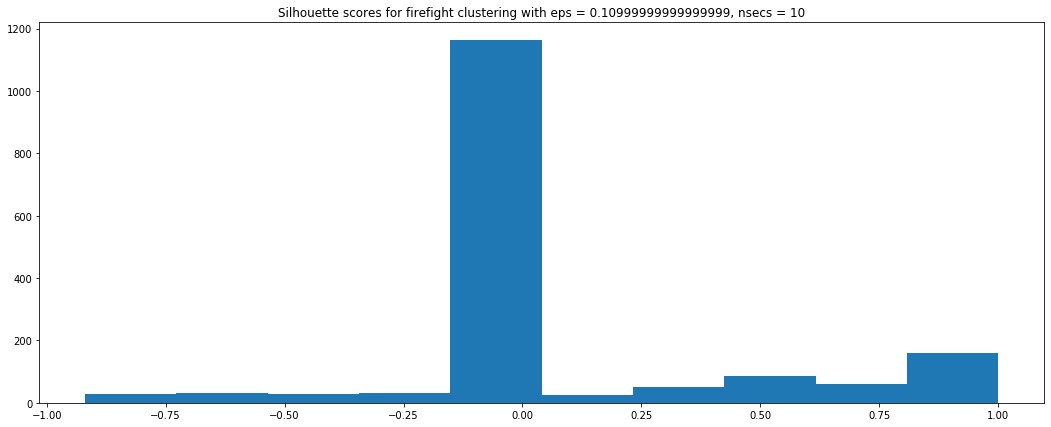

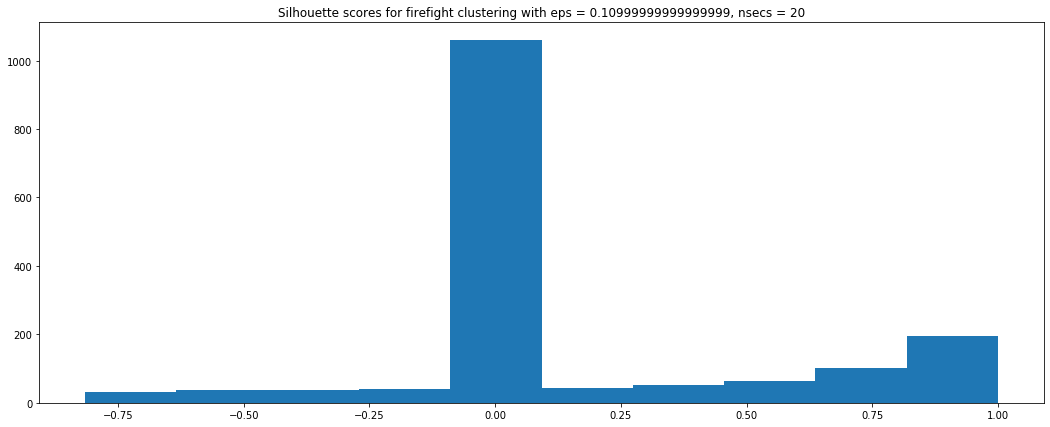

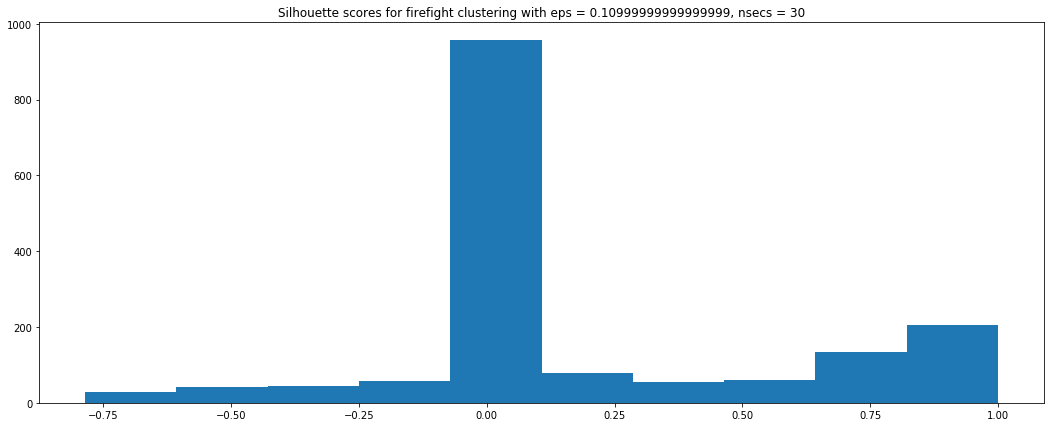

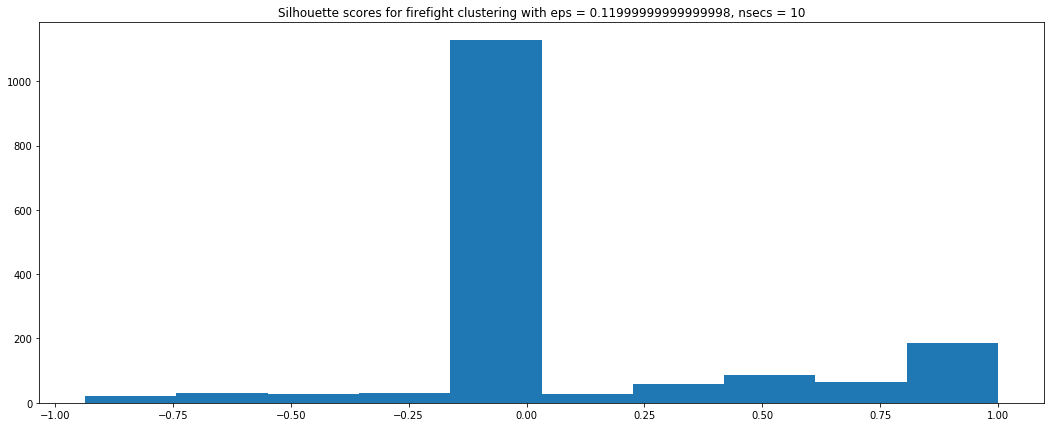

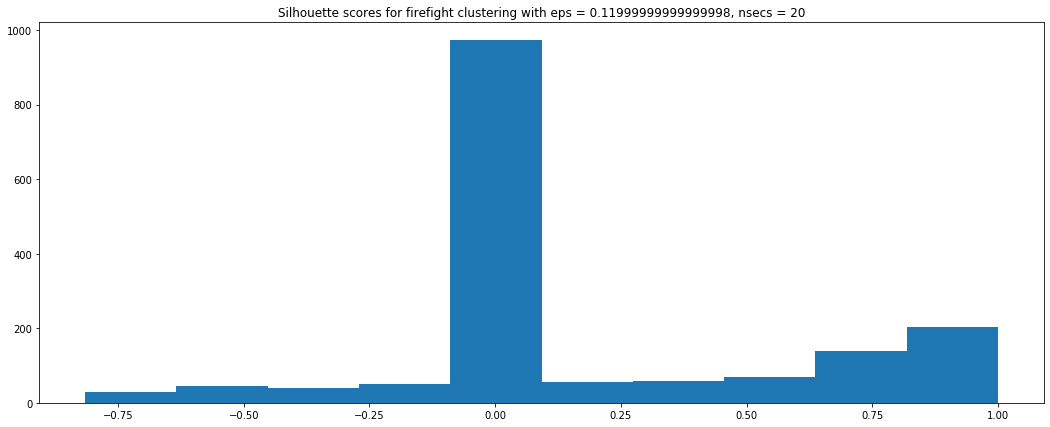

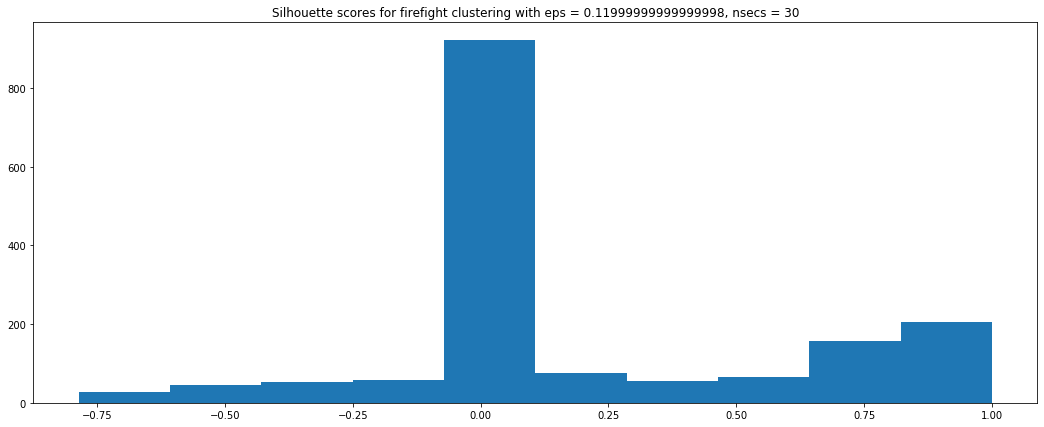

In [17]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors.nearest_centroid import NearestCentroid
import matplotlib.cm as cm

for eps in np.arange(0.08, 0.13, 0.01):
    for n_secs in [10, 20, 30]:
        print(f"Plotting for eps={eps} and n_secs={n_secs}")
        # Create a subplot 
        fig, ax = plt.subplots(1)
        fig.set_size_inches(18, 7)

        result_df = cluster_firefights(cluster_df, eps=eps, min_samples=6, n_seconds_equiv_to_quarter_map=n_secs, verbose=False, return_scaled=True)
        silhouette_scores = []
        for (fname, scaled_group) in result_df.groupby("file_round"):
            X = scaled_group[['pos_x', 'pos_y', 'seconds']]
            cluster_labels = scaled_group['firefight_cluster']
            if len(np.unique(cluster_labels)) == 1:
                round_silhouette_values = [0] * len(X)
            else:
                round_silhouette_values = silhouette_samples(X, cluster_labels)
            silhouette_scores.extend(round_silhouette_values)
        ax.hist(silhouette_scores)
        ax.title.set_text(f"Silhouette scores for firefight clustering with eps = {eps}, nsecs = {n_secs}")
   
plt.show()

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors.nearest_centroid import NearestCentroid
import matplotlib.cm as cm

range_eps = np.arange(0.006, 0.016, 0.0005)

pos_type_of_interest = 'DMG_VIC'
map_of_interest = 'de_mirage'
team_of_interest = 'CounterTerrorist'
X = cluster_df[cluster_df['pos_type'] == pos_type_of_interest]
X = X[X['map'] == map_of_interest]
X = X[X['att_side'] == team_of_interest]
X = X[['pos_x', 'pos_y']].values
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

map_im = im = plt.imread(f'../data/{map_of_interest}.png')

score_df = pd.DataFrame(columns=['eps', 'avg_score', 'avg_score_without_cluster'])

for eps in range_eps:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = DBSCAN(eps=eps, min_samples=4)
    cluster_labels = clusterer.fit_predict(X)
    #(unique, counts) = np.unique(cluster_labels, return_counts=True)
    #print("Number in each cluster: ", np.asarray((unique, counts)).T)
    n_clusters = len(np.unique(cluster_labels))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    silhouette_avg = silhouette_score(X, cluster_labels)
    avg = np.mean(sample_silhouette_values[cluster_labels.astype('int') != -1])
    print("For eps =", eps,
          "The average silhouette_score is :", silhouette_avg)
    print("Average silhouette score without cluster -1 is: ", avg)
    score_df = score_df.append({'eps': eps, 'avg_score': silhouette_avg, 'avg_score_without_cluster': avg}, ignore_index=True)

    
    y_lower = 10
    for i in np.unique(cluster_labels):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        #ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    X_og = min_max_scaler.inverse_transform(X)
    ax2.imshow(map_im)
    ax2.scatter(X_og[:, 0], X_og[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    draw_centers = False
    if draw_centers:
        # Labeling the clusters
        centroids = NearestCentroid()
        centroids.fit(X_og, cluster_labels.astype('int'))    
        centers = centroids.centroids_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=0.5, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle((f"Silhouette analysis for DBSCAN clustering on sample data with eps = {eps}"),
                 fontsize=14, fontweight='bold')

plt.show()

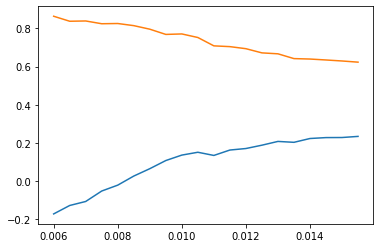

In [29]:
plt.plot(score_df['eps'], score_df['avg_score'])
plt.plot(score_df['eps'], score_df['avg_score_without_cluster'])
plt.show()

In [41]:
# Print number of firefights where all positions are clustered
map_name = 'de_mirage'
results_df = pd.DataFrame(columns=cluster_df.columns)
for name, group in cluster_df.groupby(['file_round', 'firefight_cluster']):
    if name[1] == -1:
        continue
    if (group['pos_cluster'] == -1).any():
        continue
    if not (group['pos_type'] == 'DMG_VIC').any():
        continue
    if (group['map'] != map_name).any():
        continue
    if len(group['pos_cluster'].unique()) == 1:
        continue
    results_df = pd.concat([results_df, group])
print(len(results_df))
print(results_df.head(10))




13885
       winner_side          att_side        map  seconds       pos_x  \
132436   Terrorist         Terrorist  de_mirage  114.912  402.961270   
132437   Terrorist         Terrorist  de_mirage  114.912  377.521787   
132438   Terrorist  CounterTerrorist  de_mirage  115.006  377.905713   
132439   Terrorist  CounterTerrorist  de_mirage  115.006  402.615078   
132440   Terrorist  CounterTerrorist  de_mirage  115.100  378.119936   
132441   Terrorist  CounterTerrorist  de_mirage  115.100  401.965819   
132442   Terrorist         Terrorist  de_mirage  115.116  401.821473   
132443   Terrorist         Terrorist  de_mirage  115.116  378.166255   
132444   Terrorist  CounterTerrorist  de_mirage  115.194  378.286044   
132445   Terrorist  CounterTerrorist  de_mirage  115.194  401.497443   

             pos_y  hp_dmg pos_type index                  file_round  \
132436  564.885782    27.0  DMG_ATT  2996  esea_match_13779770.dem_11   
132437  533.120871    27.0  DMG_VIC  2996  esea_match_1

In [42]:
# Do one-hot encoding for each team seperately and each type seperately (except DMG_VIC and DMG_ATT, which are done together)
pos_types = [t for t in cluster_df['pos_type'].unique() if t not in ['DMG_VIC', 'DMG_ATT']]
dummy_cols = []
for pos_type in pos_types:
    mask = (results_df['pos_type'] == pos_type)
    group = results_df[mask]
    # Differentiate T and CT cluster by adding max to all T
    max_ct_pos_cluster = group.loc[(group['att_side'] == 'CounterTerrorist'), 'pos_cluster'].max()
    group.loc[(group['att_side'] == "Terrorist"), 'pos_cluster'] += max_ct_pos_cluster
    dummies = pd.get_dummies(group['pos_cluster'])
    print(f"REAL COLS {dummies.columns}")
    dummies.columns = [f"CT_{pos_type}_{c}" if c < max_ct_pos_cluster else f"T_{pos_type}_{c - max_ct_pos_cluster}" for c in dummies.columns]
    dummy_cols.extend(dummies.columns)
    for c in dummies.columns:
        results_df[c] = 0
    results_df.loc[mask, dummies.columns] = dummies
mask = (results_df['pos_type'] == 'DMG_ATT') | (results_df['pos_type'] == 'DMG_VIC')
group = results_df[mask]
max_ct_pos_cluster = group.loc[(group['att_side'] == 'CounterTerrorist'), 'pos_cluster'].max()
group.loc[(group['att_side'] == "Terrorist"), 'pos_cluster'] += max_ct_pos_cluster
dummies = pd.get_dummies(group['pos_cluster'])
dummies.columns = [f"CT_DMG_{c}" if c < max_ct_pos_cluster else f"T_DMG_{c - max_ct_pos_cluster}" for c in dummies.columns]
dummy_cols.extend(dummies.columns)
for c in dummies.columns:
    results_df[c] = 0
results_df.loc[mask, dummies.columns] = dummies

#sided_results_df = results_df.copy()
#sided_results_df[dummy_cols] = sided_results_df[dummy_cols].multiply((sided_results_df['att_side'] == 'Terrorist').astype(int)*2 - 1, axis=0)

print(dummy_cols)
agg_fn = {c: 'sum' for c in dummy_cols}
agg_fn['firefight_net_t_dmg'] = 'first'
agg_fn['firefight_net_ct_dmg'] = 'first'
agg_fn['att_side'] = 'first'
agg_results_df = results_df.groupby(['file_round', 'firefight_cluster']).agg(agg_fn)
X = agg_results_df[dummy_cols]
#print((agg_results_df['att_side'] == 'Terrorist').astype(int)*2 - 1)
y =  agg_results_df['firefight_net_t_dmg'] - agg_results_df['firefight_net_ct_dmg'] 
print(X)
print(y)


REAL COLS Float64Index([  1.0,   2.0,  10.0,  12.0,  13.0,  14.0,  15.0,  20.0,  33.0,
               36.0,  39.0,  60.0,  65.0,  91.0,  93.0, 104.0, 105.0, 106.0,
              107.0, 110.0, 112.0, 116.0, 128.0, 154.0, 160.0, 173.0, 226.0,
              252.0, 266.0],
             dtype='float64')
REAL COLS Float64Index([  0.0,   1.0,   2.0,  19.0,  39.0,  41.0,  45.0,  50.0,  64.0,
               66.0,  73.0,  81.0,  91.0,  94.0, 101.0, 103.0, 164.0, 165.0,
              166.0, 169.0, 170.0, 172.0, 173.0, 175.0, 176.0, 178.0, 185.0,
              187.0, 193.0, 197.0, 198.0, 209.0, 210.0, 214.0, 231.0, 232.0,
              234.0, 252.0, 261.0, 279.0, 285.0, 297.0, 300.0, 309.0, 315.0,
              381.0, 394.0],
             dtype='float64')
REAL COLS Float64Index([  0.0,   1.0,   7.0,   9.0,  10.0,  23.0,  37.0,  43.0,  49.0,
               87.0,  88.0,  89.0,  91.0,  92.0,  93.0,  94.0,  97.0, 101.0,
              103.0, 104.0, 105.0, 109.0, 112.0, 115.0, 136.0],
             dtype


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


REAL COLS Float64Index([  0.0,   1.0,   3.0,   5.0,   6.0,   7.0,   9.0,  11.0,  21.0,
               28.0,  39.0,  41.0,  53.0,  58.0,  74.0,  75.0,  82.0,  98.0,
              108.0, 118.0, 129.0, 135.0, 163.0, 170.0, 171.0, 172.0, 175.0,
              176.0, 178.0, 181.0, 182.0, 188.0, 189.0, 190.0, 200.0, 216.0,
              219.0, 220.0, 231.0, 239.0, 247.0, 251.0, 255.0, 266.0, 274.0,
              286.0, 290.0, 304.0, 305.0, 311.0, 318.0, 333.0, 342.0, 390.0,
              396.0, 398.0],
             dtype='float64')
['CT_Smoke_1.0', 'CT_Smoke_2.0', 'CT_Smoke_10.0', 'CT_Smoke_12.0', 'CT_Smoke_13.0', 'CT_Smoke_14.0', 'CT_Smoke_15.0', 'CT_Smoke_20.0', 'CT_Smoke_33.0', 'CT_Smoke_36.0', 'CT_Smoke_39.0', 'CT_Smoke_60.0', 'CT_Smoke_65.0', 'CT_Smoke_91.0', 'CT_Smoke_93.0', 'T_Smoke_0.0', 'T_Smoke_1.0', 'T_Smoke_2.0', 'T_Smoke_3.0', 'T_Smoke_6.0', 'T_Smoke_8.0', 'T_Smoke_12.0', 'T_Smoke_24.0', 'T_Smoke_50.0', 'T_Smoke_56.0', 'T_Smoke_69.0', 'T_Smoke_122.0', 'T_Smoke_148.0', 'T_Smoke_16

                                              CT_Smoke_1.0  CT_Smoke_2.0  \
file_round                 firefight_cluster                               
esea_match_13779770.dem_11 0                             0             0   
esea_match_13779770.dem_14 0                             0             0   
esea_match_13779770.dem_15 0                             0             0   
                           1                             0             0   
esea_match_13779770.dem_21 1                             0             0   
...                                                    ...           ...   
esea_match_13780681.dem_15 0                             0             0   
esea_match_13780681.dem_3  1                             0             0   
                           2                             0             0   
esea_match_13780681.dem_6  0                             0             0   
                           1                             0             0   

           

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
import shap
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("LINEAR REGRESSION")
mod = LinearRegression()
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)
print(f"Linear Regression MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print("RANDOM FOREST")
mod = RandomForestRegressor()
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)
print(f"RF MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"RF MSE: {metrics.mean_squared_error(y_test, y_pred)}")

print("TUNED RF:")
param_dist = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# run randomized search
rf_random = RandomizedSearchCV(estimator = mod, param_distributions = param_dist, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
mod = rf_random.best_estimator_
y_pred = mod.predict(X_test)
print(f"RF MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"RF MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print("RF FEATURE IMPORTANCES:")
sorted_idx = mod.feature_importances_.argsort()
print([x for x in zip(X.columns[-sorted_idx], mod.feature_importances_[-sorted_idx])])

print("RF PERMUTATION IMPORTANCES:")
perm_importance = permutation_importance(mod, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
print([x for x in zip(X.columns[-sorted_idx], perm_importance.importances_mean[-sorted_idx])])

LINEAR REGRESSION
Linear Regression MSE: 4.709662443794663e+26
RANDOM FOREST
RF MAE: 72.80136688995852
RF MSE: 8688.923258543446
TUNED RF:
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.1min finished


RF MAE: 71.76572125613295
RF MSE: 7482.020880868899
RF FEATURE IMPORTANCES:
[('CT_DMG_102.0', 0.0023359869815036145), ('CT_Incendiary_37.0', 3.97849258935684e-06), ('T_DMG_59.0', 0.0), ('CT_Incendiary_43.0', 0.0), ('CT_Incendiary_49.0', 0.00019927123525906727), ('T_Incendiary_0.0', 0.0), ('T_DMG_55.0', 0.0), ('CT_DMG_27.0', 5.236579975040768e-07), ('T_Incendiary_1.0', 0.0025468305679406614), ('T_Incendiary_10.0', 0.0), ('CT_DMG_26.0', 1.2973932076497221e-05), ('CT_DMG_25.0', 0.0024538778404865967), ('T_DMG_46.0', 8.12525680300666e-05), ('T_Incendiary_49.0', 0.0), ('CT_DMG_20.0', 0.01723846589480409), ('T_Incendiary_6.0', 0.004219837235681802), ('CT_Incendiary_7.0', 0.0), ('CT_DMG_28.0', 1.2581447461256963e-05), ('CT_DMG_29.0', 0.0), ('T_DMG_96.0', 0.0), ('T_HE_46.0', 0.0), ('T_HE_50.0', 0.0032912376791009498), ('CT_DMG_225.0', 0.0), ('T_DMG_90.0', 0.0), ('T_HE_67.0', 4.339712724668302e-06), ('T_DMG_87.0', 0.0), ('T_HE_70.0', 5.16542175898084e-06), ('CT_DMG_33.0', 0.0013599793860344098)

[('CT_DMG_236.0', 0.0), ('CT_DMG_185.0', 0.0), ('CT_DMG_284.0', 0.0), ('T_Flash_104.0', 0.0), ('CT_DMG_157.0', 0.0), ('T_DMG_27.0', 0.0), ('CT_DMG_220.0', 0.0), ('CT_DMG_254.0', 0.0), ('T_Incendiary_28.0', 0.0), ('T_DMG_125.0', 0.0), ('T_DMG_81.0', 0.0), ('T_DMG_148.0', 0.0), ('T_DMG_212.0', 0.0), ('CT_DMG_256.0', 0.0), ('T_DMG_84.0', 0.0), ('T_DMG_100.0', 0.0), ('T_DMG_86.0', 0.0), ('CT_Flash_108.0', 0.0), ('T_DMG_29.0', 0.0007676139275653027), ('T_DMG_151.0', 0.0), ('T_Flash_20.0', -1.7077991080688416e-05), ('CT_DMG_232.0', 0.0), ('T_DMG_73.0', 0.0), ('CT_DMG_91.0', 0.0), ('CT_DMG_69.0', 0.0), ('T_DMG_78.0', 0.0), ('CT_Incendiary_23.0', 3.992967185451057e-06), ('CT_DMG_191.0', 0.0), ('T_Flash_134.0', 0.0), ('CT_DMG_106.0', 0.0), ('T_DMG_50.0', 0.0), ('CT_DMG_154.0', 0.0), ('T_DMG_20.0', -0.00011741833556186965), ('CT_Flash_28.0', 0.0), ('CT_DMG_88.0', 0.0), ('T_DMG_122.0', 0.0), ('CT_DMG_301.0', 0.0), ('CT_DMG_124.0', 0.0), ('T_DMG_158.0', 0.0), ('T_HE_11.0', 0.0), ('CT_Flash_41.0', 

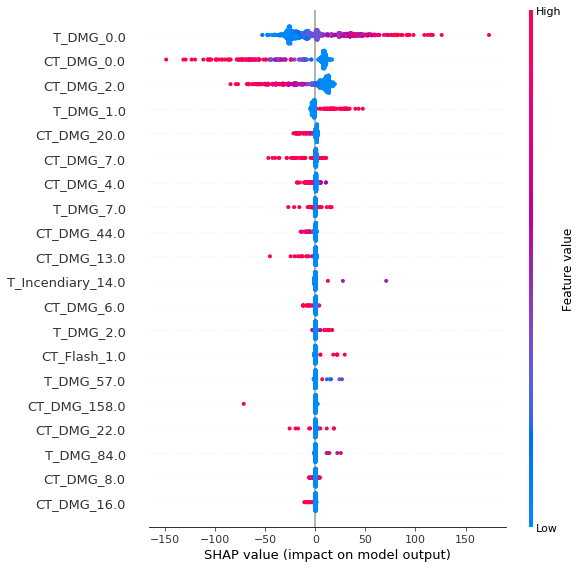

In [51]:
import shap
explainer = shap.TreeExplainer(mod)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)